In [1]:
from torchvision.models import resnet50, vgg19
from torchvision.io.image import read_image
import torch
from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchvision import transforms
import matplotlib.pyplot as plt
from typing import List
from torchcam.utils import overlay_mask

In [2]:
resnet50_model = resnet50(weights="ResNet50_Weights.DEFAULT").eval()
vgg19_model = vgg19(weights="VGG19_Weights.DEFAULT").eval()
img = read_image("nam-anh-QJbyG6O0ick-unsplash.jpg")
trans_params = {"ImageNet_transformation":
  {"Resize": {"h": 224,"w": 224},
  "Normalize": {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]}}}


In [3]:
import torchvision
import sys
import os

# Set up paths
module_path = os.path.abspath(os.path.join("../../"))
if module_path not in sys.path:
    sys.path.append(module_path)

from easy_explain import CAMExplain

/Users/stavrostheocharis/Desktop/Projects/easy_explain/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
explainer = CAMExplain(model = vgg19_model)  # Use the model of your choice here


/Users/stavrostheocharis/Desktop/Projects/easy_explain/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
INFO:root:The cams per target layer are: [torch.Size([1, 224, 224]), torch.Size([1, 224, 224]), torch.Size([1, 224, 224]), torch.Size([1, 224, 224]), torch.Size([1, 112, 112]), torch.Size([1, 112, 112]), torch.Size([1, 112, 112]), torc

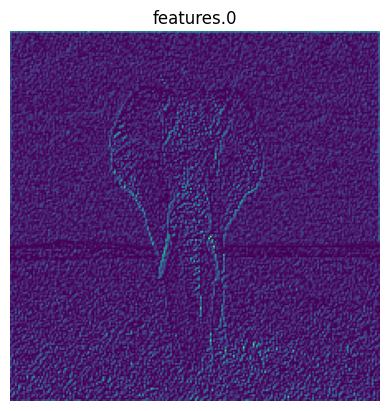

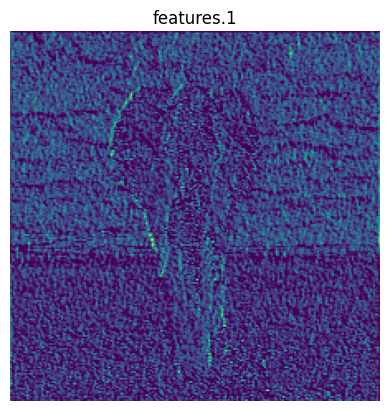

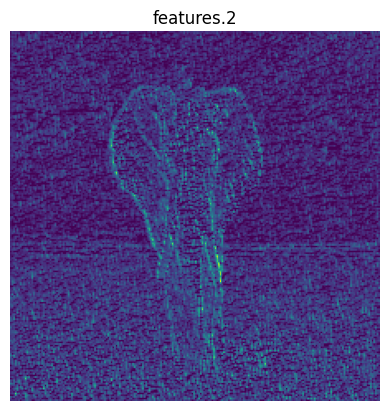

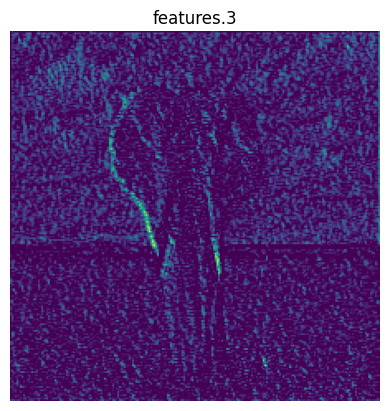

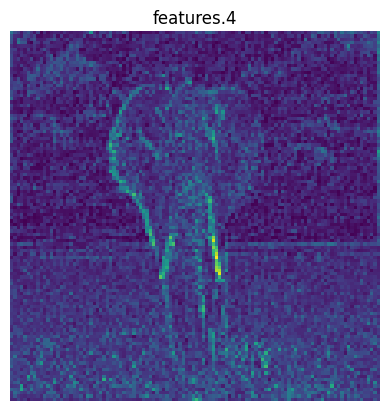

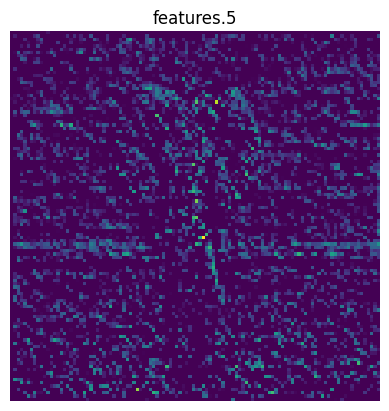

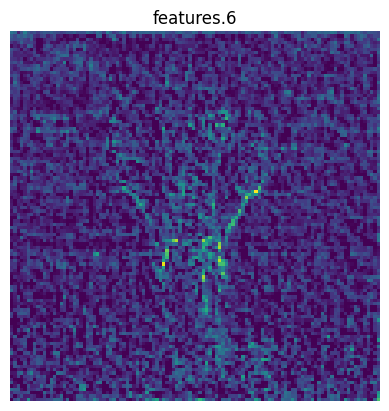

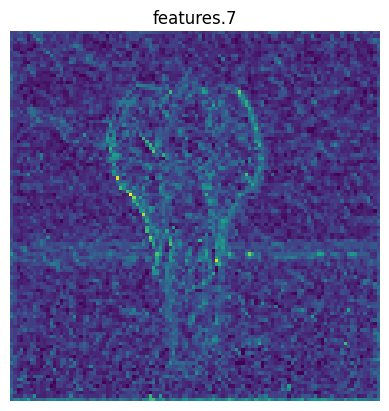

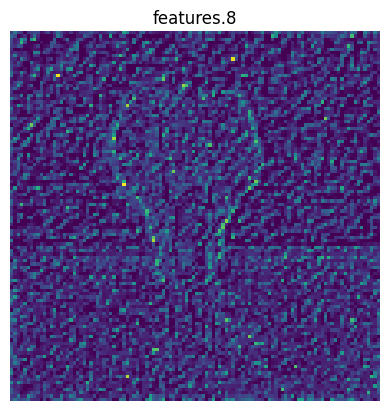

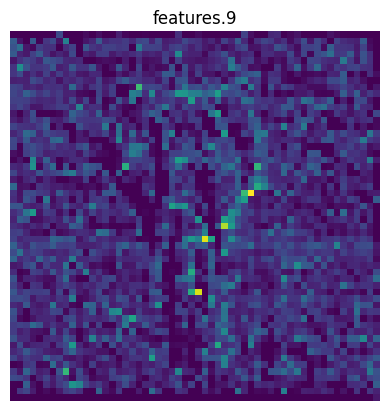

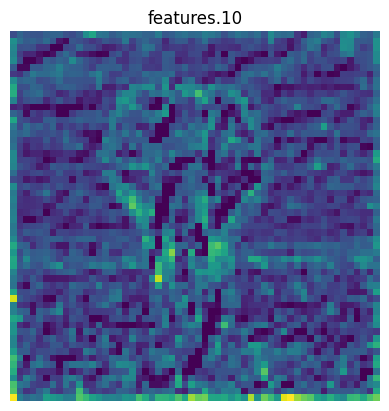

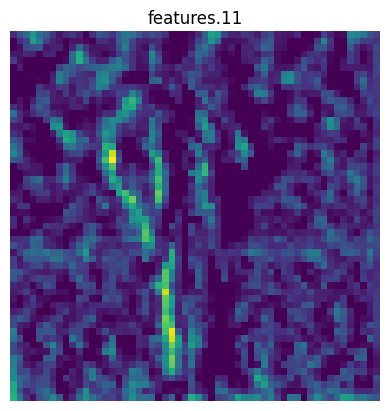

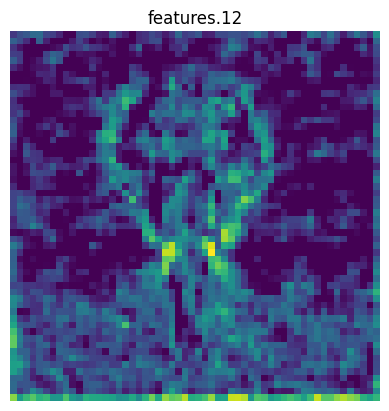

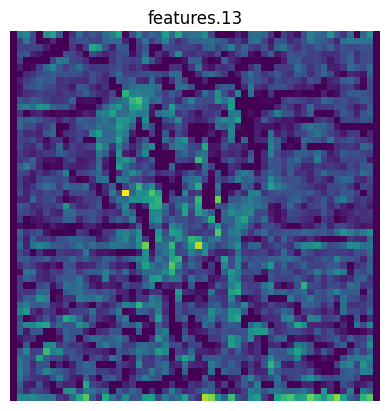

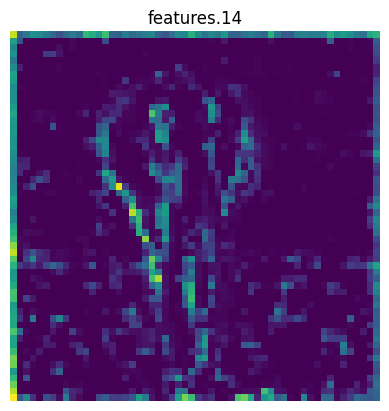

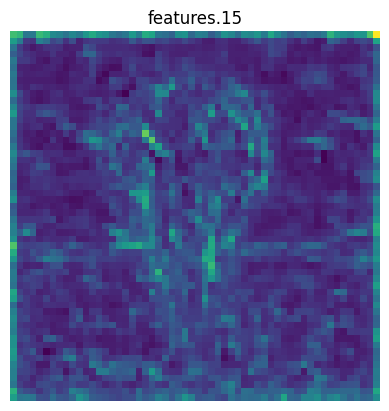

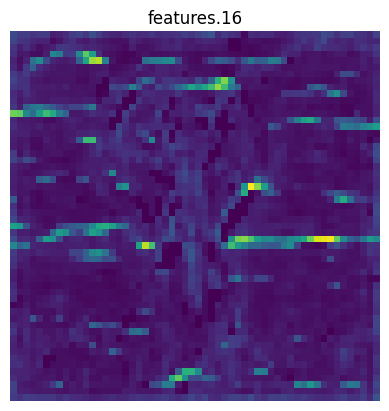

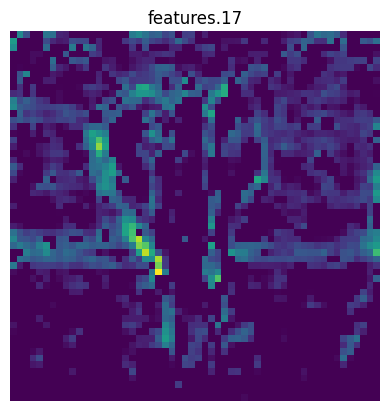

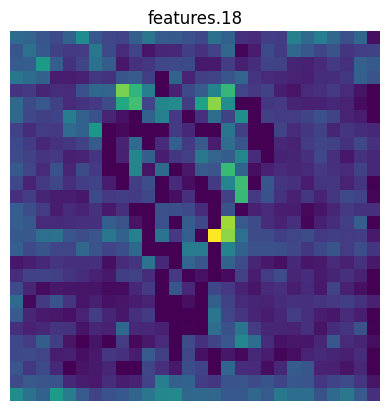

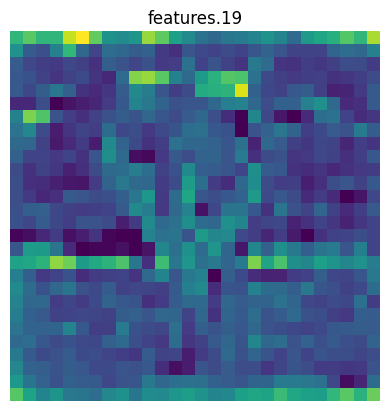

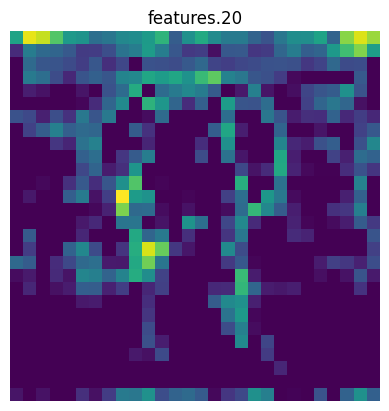

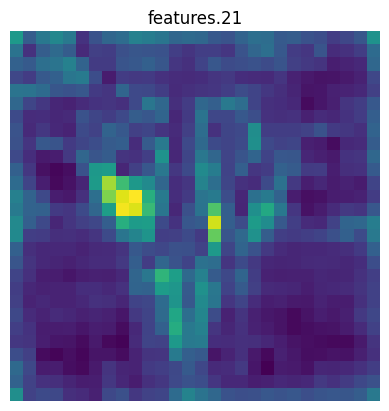

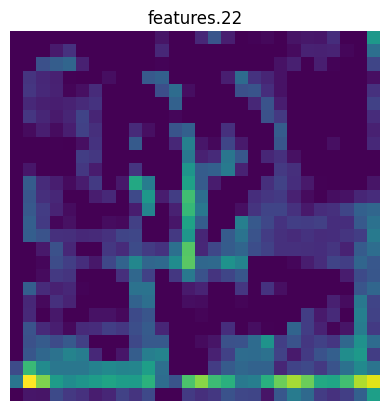

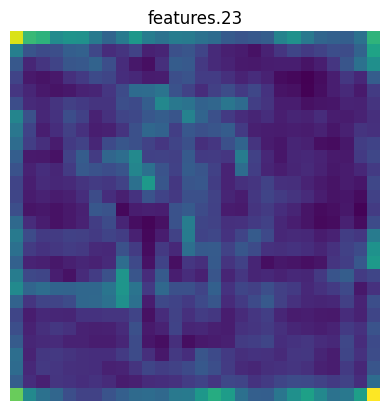

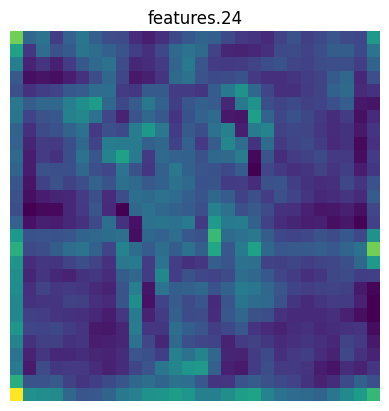

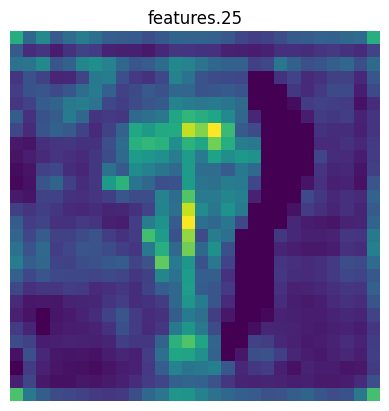

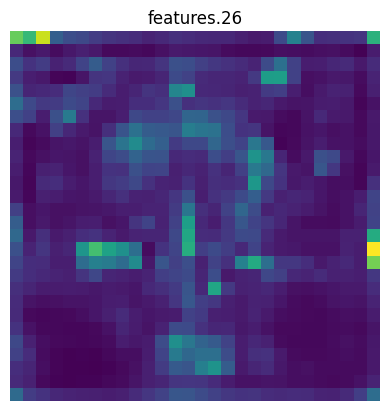

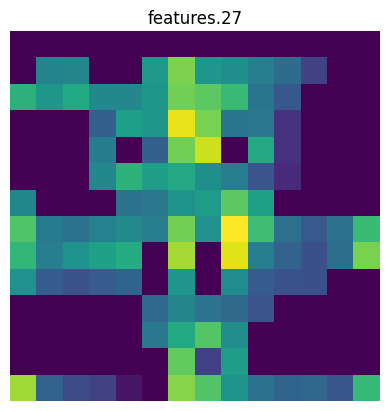

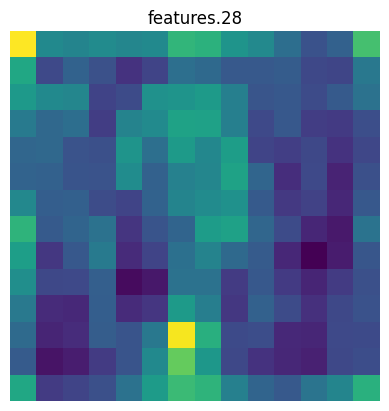

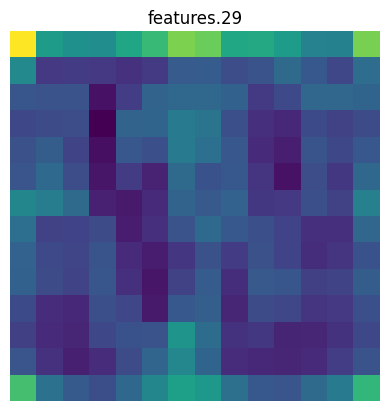

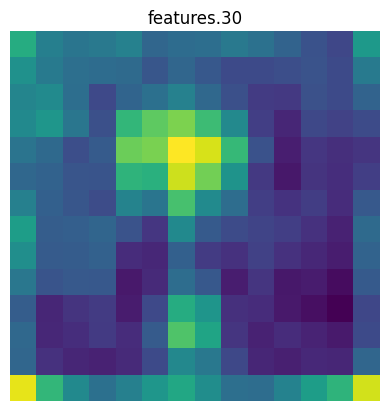

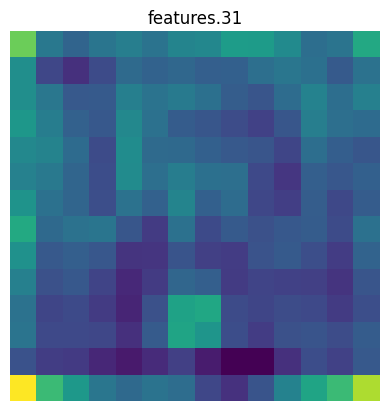

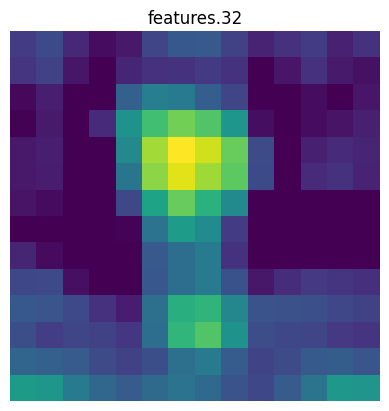

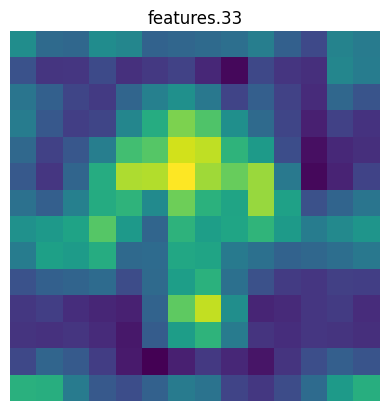

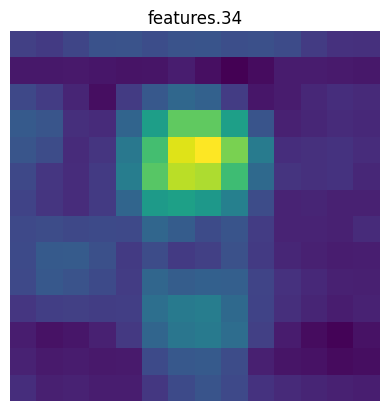

KeyboardInterrupt: 

In [5]:
explainer = CAMExplain(vgg19_model)  # Use the model of your choice here
input_tensor = explainer.transform_image(img, trans_params["ImageNet_transformation"])
# Keep the features layers until the last CNN layer
features = []
features = [vgg19_model.features[x] for x in range(35)]

explainer.generate_explanation(img, input_tensor, target_layer=features)



/Users/stavrostheocharis/Desktop/Projects/easy_explain/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/stavrostheocharis/Desktop/Projects/easy_explain/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/stavrostheocharis/Desktop/Projects/easy_explain/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior 

The cams per target layer are:  [torch.Size([1, 7, 7])]


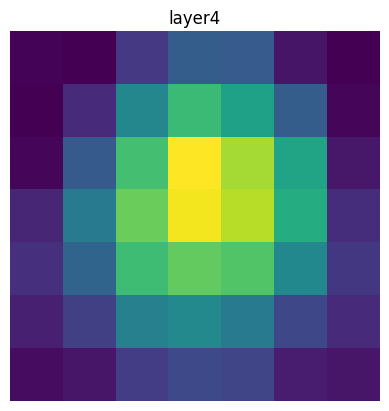

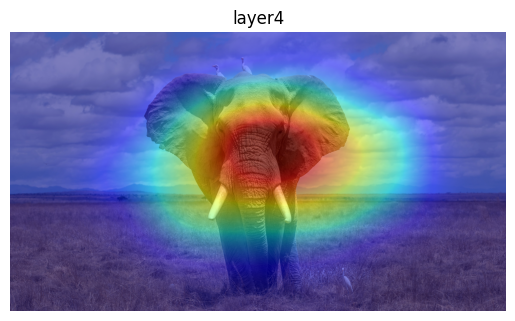

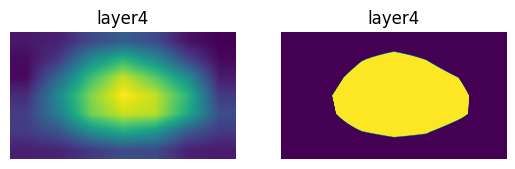

The cams per target layer are:  [torch.Size([1, 28, 28]), torch.Size([1, 14, 14]), torch.Size([1, 7, 7])]


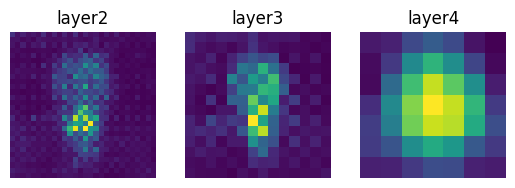

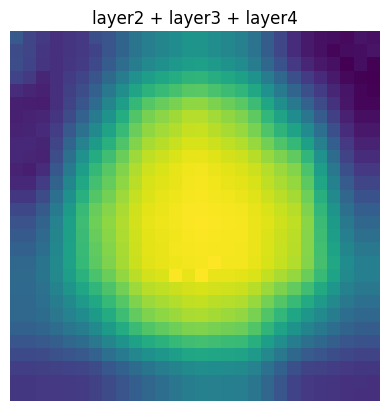

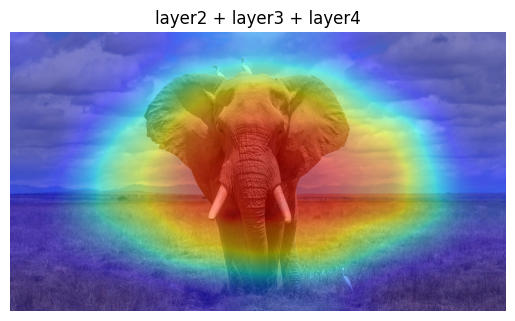

In [6]:
# Initialize models
resnet50_model = resnet50(pretrained=True).eval()
vgg19_model = vgg19(pretrained=True).eval()

# Load and preprocess image
img = read_image("nam-anh-QJbyG6O0ick-unsplash.jpg")
trans_params = {
    "ImageNet_transformation": {
        "Resize": {"h": 224, "w": 224},
        "Normalize": {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]}
    }
}

explainer = CAMExplain(resnet50_model)  # Use the model of your choice here
input_tensor = explainer.transform_image(img, trans_params["ImageNet_transformation"])
explainer.generate_explanation(img, input_tensor, multiple_layers=["layer2", "layer3", "layer4"])

In [9]:
import torch
from torchvision.transforms import functional as F
from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Optional

class CAMExplain:
    def __init__(self, model):
        self.model = model
    
    def transform_image(self, img, trans_params):
        """Transform an image based on specified parameters."""
        resize = trans_params["Resize"]
        normalize = trans_params["Normalize"]
        input_tensor = F.normalize(
            F.resize(img, (resize["h"], resize["w"])) / 255.0,
            normalize["mean"],
            normalize["std"],
        )
        return input_tensor.unsqueeze(0)  # Add batch dimension

    def extract_cam(self, img, input_tensor, target_layer=None, localisation_mask: bool = True, multiple_layers: Optional[List[str]] = None, alpha=0.5):
        if multiple_layers:
            # Handle multiple layers with LayerCAM
            self._handle_multiple_layers(input_tensor, img, multiple_layers, alpha)
        else:
            cam_extractor = SmoothGradCAMpp(self.model, target_layer=target_layer)
            output = self.model(input_tensor)
            cams = [cam_extractor(output.argmax(dim=1).item(), output)]
            print("CAM generated:", cams[0].shape)  # Print CAM shape to verify
            self.visualize_cam(cams, img, alpha)

        if localisation_mask:
            self.get_localisation_mask(self.model, input_tensor, img)

    def get_multiple_layers_result(self, model, img, input_tensor, layers: List[str], alpha):
        """Handle CAM extraction and visualization for multiple layers."""
        cam_extractor = LayerCAM(model, layers)
        output = model(input_tensor)
        cams = cam_extractor(output.argmax(dim=1).item(), output)
        self.visualize_cam(cams, img, alpha, is_fused=True)

    def get_localisation_mask(self, model, input_tensor, img):
        """Generate and visualize localization masks."""
        cam_extractor = LayerCAM(model)
        output = model(input_tensor)
        cams = cam_extractor(output.argmax(dim=1).item(), output)
        for cam in cams:
            resized_cam = F.resize(F.to_pil_image(cam.squeeze(0)), img.shape[-2:])
            segmap = F.to_pil_image(
                (F.resize(cam, img.shape[-2:]).squeeze(0) >= 0.5).to(torch.float32)
            )
            _, axes = plt.subplots(1, 2)
            axes[0].imshow(resized_cam)
            axes[0].axis("off")
            axes[1].imshow(segmap)
            axes[1].axis("off")
            plt.show()

    def visualize_cam(self, cams, img, alpha, is_fused=False):
        # Check if img is a PIL Image; if not, convert it
        if not isinstance(img, Image.Image):
            img_pil = F.to_pil_image(img)
        else:
            img_pil = img  # img is already a PIL Image, no need to convert

        if not is_fused:
            for cam in cams:
                # Ensure cam is a tensor before converting to PIL image
                if isinstance(cam, torch.Tensor):
                    cam_pil = F.to_pil_image(cam.squeeze().cpu(), mode="F")
                    result = overlay_mask(img_pil, cam_pil, alpha=alpha)
                    plt.imshow(result)
                    plt.axis("off")
                    plt.show()
        else:
            # Handle fused CAM visualization as per the original logic
            fused_cam = torch.mean(torch.stack([cam.squeeze(0) for cam in cams]), dim=0)
            result = overlay_mask(
                F.to_pil_image(img),
                F.to_pil_image(fused_cam, mode="F"),
                alpha=alpha,
            )
            plt.imshow(result)
            plt.axis("off")
            plt.title("Fused CAM")
            plt.show()



In [10]:
# Initialize models
resnet50_model = resnet50(pretrained=True).eval()
vgg19_model = vgg19(pretrained=True).eval()

# Load and preprocess image
img = read_image("nam-anh-QJbyG6O0ick-unsplash.jpg")
trans_params = {
    "ImageNet_transformation": {
        "Resize": {"h": 224, "w": 224},
        "Normalize": {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]}
    }
}

explainer = CAMExplain(resnet50_model)  # Use the model of your choice here
input_tensor = explainer.transform_image(img, trans_params["ImageNet_transformation"])
explainer.extract_cam(to_pil_image(img), input_tensor, target_layer="layer4", localisation_mask=False)


AttributeError: 'list' object has no attribute 'shape'

In [8]:
# Initialize models
resnet50_model = resnet50(pretrained=True).eval()
vgg19_model = vgg19(pretrained=True).eval()

# Load and preprocess image
img = read_image("nam-anh-QJbyG6O0ick-unsplash.jpg")
trans_params = {
    "ImageNet_transformation": {
        "Resize": {"h": 224, "w": 224},
        "Normalize": {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]}
    }
}

# Instantiate Explainability class for ResNet50
explainer_resnet = Explainability(resnet50_model)
input_tensor = explainer_resnet.transform_image(img, trans_params["ImageNet_transformation"])
explainer_resnet.extract_cam(img, input_tensor, multiple_layers=["layer2", "layer3", "layer4"])

# Instantiate Explainability class for VGG19
explainer_vgg19 = Explainability(vgg19_model)
input_tensor = explainer_vgg19.transform_image(img, trans_params["ImageNet_transformation"])
features = [vgg19_model.features[x] for x in range(35)]  # Example feature extraction
explainer_vgg19.extract_cam(img, input_tensor, target_layer=features)


NameError: name 'Explainability' is not defined